## Non-holonomic RRT 

**Team Name**: Over 9000 <br>
**Team Members**: Avneesh Mishra (2021701032), Laksh Nanwani (2021701002) <br>

This file is being handled by Avneesh Mishra (2021701032), GitHub: [TheProjectsGuy](https://github.com/TheProjectsGuy)

In [81]:
# Import everything
# Library
from lib import rrt_planar_solver as RRT
# Main libraries
import numpy as np
import matplotlib.pyplot as plt
# Utilities
import time
import pickle
import os

### Simple RRT Experiment

Declare a map of the environment. This is given as a list of Obstacles in a map. This is declared below for the given environment.

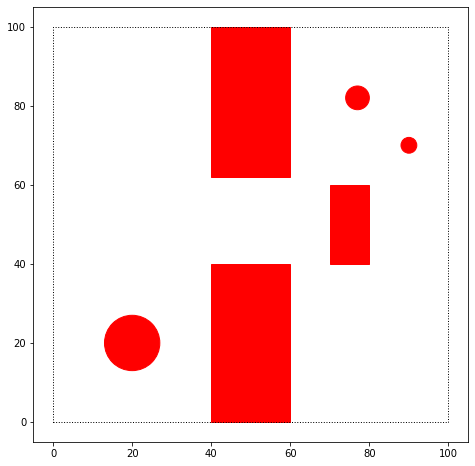

In [2]:
# Obstacles
rect1 = RRT.Rectangle(40, 62, 60, 100)
rect2 = RRT.Rectangle(70, 40, 80, 60)
rect3 = RRT.Rectangle(40, 0, 60, 40)
cir1 = RRT.Circle(20, 20, 7)
cir2 = RRT.Circle(77, 82, 3)
cir3 = RRT.Circle(90, 70, 2)
# Map
rrt_map = RRT.Map(100, 100, [rect1, rect2, rect3, cir1, cir2, cir3])
# Show the map
fig = plt.figure(figsize=(8, 8))
ax = fig.add_subplot()
ax.set_aspect('equal', 'box')
rrt_map.draw_on_axes(ax, ":", color="red")
plt.show()

Creating the main RRT problem

In [3]:
# Solver
rrt_solver = RRT.SolverRRT(rrt_map)
# Start and end
start_point = (5, 5)
end_point = (95, 95)
# Output folders
tree_out = "./out"
path_out = "./out_path"
save_fname_prefix = "./run_default"
# Distances
end_dist = 5.0  # Within goal
max_dist = 6.0  # Max dist. to add nodes to the tree
obj_dist = 5.0  # Distance for nodes to maintain from obstacles

Solve for one start to end, with output images in the folder

In [4]:
# Time it
print("Starting the RRT solver")
start_time = time.time()
# Main solver
rrt_path = rrt_solver.solve(start_point, end_point, end_dist, 
    max_dist, obj_dist, out_dir=tree_out)
# Results
end_time = time.time()
print(f"It took {end_time-start_time:.6f} seconds!")
print(f"Explored {len(rrt_solver.node_tree)} nodes and found a path "
    f"with {rrt_path.shape[0]} points")

Starting the RRT solver
[INFO]: Output directory 'c:\Users\123av\Documents\IIITH\Assignments\Robotic Planning and Navigation - EC4-403\assignment1-over-9000\out' created
It took 61.546708 seconds!
Explored 161 nodes and found a path with 33 points


The tree looks like following

<img src="./images/tree_default.png" width=300 style="background-color:white" alt="Tree shown on the map"/>

This took about 2 minutes!


Let's visualize the trajectory

In [5]:
# Save trajectory output
rrt_solver.save_results_figs(rrt_path, start_point, end_point, 
    path_out)

[INFO]: Output directory 'c:\Users\123av\Documents\IIITH\Assignments\Robotic Planning and Navigation - EC4-403\assignment1-over-9000\out_path' created


Save and restore all files (for backup)

In [6]:
# The solver
fhdlr = open(f"{save_fname_prefix}.pkl", "wb")
pickle.dump(rrt_solver, fhdlr)
fhdlr.close()

In [7]:
# The RRT solution
np.save(f"{save_fname_prefix}.npy", rrt_path)

In [8]:
# Load RRT solver
fhdlr = open(f"{save_fname_prefix}.pkl", "rb")
rrt_s : RRT.SolverRRT = pickle.load(fhdlr)
fhdlr.close()
# rrt_solver = rrt_s

In [10]:
# Load the RRT solution
rrt_p: np.ndarray = np.load(f"{save_fname_prefix}.npy")

A path is shown below

<img src="./images/path_default.png" width=300 style="background-color:white" alt="Path"/>


#### Some other runs

This is the first run

<img src="./images/tree0.png" width=300 style="background-color:white" alt="Tree shown on the map"/>
<img src="./images/path0.png" width=300 style="background-color:white" alt="Path"/>


This one took 7 minutes! It has a smaller `max_dist` value

<img src="./images/tree1.png" width=300 style="background-color:white" alt="Tree shown on the map"/>
<img src="./images/path1.png" width=300 style="background-color:white" alt="Path"/>

#### Saving as videos

To save the files as windows, use the `tools` folder

Run the following commands in the root folder

This is for the tree

```sh
python ./tools/imgs_to_vid.py -i ./out/ -o "out_tree.mp4" -f 20
```

This is for the path

```sh
python ./tools/imgs_to_vid.py -i ./out_path/ -o "out_path.mp4" -f 10
```

Now, you can [merge them in VLC](https://www.aiseesoft.com/tutorial/merge-videos-vlc.html), or use [clideo](https://clideo.com/merge-video). The output is submitted in the README.md file.


### Non-Holonomic Motion

We have waypoints through RRT. Let's follow them through wheel motions. For consistency, the above file is loaded for path.


**Note**: Assuming that the vehicle is a differential drive that can rotate about the center and move forwards (where it is heading). The odometry to reach from one pose to another is to do the following:
- Rotate to align with the line connecting the two poses
- Translate forward on that line
- Perform final rotation to align with the final pose

In [114]:
# Wheelbase
wb = 2
# Poses
xy_vals : np.ndarray = rrt_p    # List of [x, y] poses
# RRT map
rrt_map = rrt_s.map
# Increments. Divide by time (dt) to get the velocities
min_dth = np.deg2rad(10)
min_dl = 2.0
# Output folder
path_out = "./wheels_out"

In [115]:
# Rotate vehicle at point
def rotate_at_point(cpose, dth, wb):
    """
        Rotate `dth` counter-clockwise at the center pose `cpose`
        (which contains `x, y, theta` of the center). `wb` is the
        wheelbase. Returns the pose of left, right, and center wheel
        after the rotation. The pose of left and right wheel is 
        (x, y), but the pose of center is (x, y, th).
    """
    x, y, th = cpose
    R = np.array([
        [np.cos(th+dth), -np.sin(th+dth)],
        [np.sin(th+dth),  np.cos(th+dth)]])
    P = np.array([x, y])
    # Left and right in local
    l_l = np.array([0,  wb/2])
    l_r = np.array([0, -wb/2])
    # Final
    f_l = P + R @ l_l
    f_r = P + R @ l_r
    return f_l.tolist(), f_r.tolist(), [x, y, th+dth]

In [116]:
# Translate straight
def trans_straight(cpose, d, wb):
    """
        Translate by distance `d` in the heading direction. `cpose` is
        the pose (x, y, theta) of the center. `wb` is the wheelbase.
        Returns the pose of left, right, and center wheel after the
        translation. The pose of left and right wheel is (x, y), but
        the pose of center is (x, y, th).
    """
    x, y, th = cpose
    R = np.array([
        [np.cos(th), -np.sin(th)],
        [np.sin(th),  np.cos(th)]])
    P = np.array([x, y])
    # Left and right in local
    l_l = np.array([0,  wb/2])
    l_r = np.array([0, -wb/2])
    # Translation vector
    d_v = np.array([d*np.cos(th), d*np.sin(th)])
    # Final poses
    f_l = P + R @ l_l + d_v
    f_r = P + R @ l_r + d_v
    return f_l.tolist(), f_r.tolist(), [x+d_v[0], y+d_v[1], th]

In [117]:
# Starting pose of center
pc = [float(xy_vals[0,0]), float(xy_vals[0,1]), 0]

In [118]:
# Initial pose
center_pose = pc
th = center_pose[2] # Angle
cxy = np.array([center_pose[0], center_pose[1]])
l_l = np.array([0, wb/2])
l_r = np.array([0, -wb/2])
R = np.array([[np.cos(th), -np.sin(th)], [np.sin(th), np.cos(th)]])
pl = cxy + R @ l_l
pr = cxy + R @ l_r
# Log
poses_center = [[cxy[0], cxy[1]]]
poses_left = [[pl[0], pl[1]]]
poses_right = [[pr[0], pr[1]]]
# Go from first to last-1 node: each loop is node i to i+1
for i in range(len(xy_vals)-1):
    xi, yi, curr_th = center_pose   # Presently here
    xj, yj = xy_vals[i+1]   # Go here
    des_th = np.arctan2((yj-yi), (xj-xi)) # Desired heading
    del_th = des_th - curr_th   # Desired rotation
    des_l = RRT.euclidean_dist((xi, yi), (xj, yj))  # Desired trans
    # Step 1: Rotate in steps of min_dth
    num_steps = int(del_th/min_dth)
    for _ in range(abs(num_steps)):
        mul = 1 if num_steps > 0 else -1
        dth = min_dth * mul
        lp, rp, cp = rotate_at_point(center_pose, dth, wb)
        poses_left.append([lp[0], lp[1]])
        poses_right.append([rp[0], rp[1]])
        poses_center.append([cp[0], cp[1]])
        center_pose = cp
    # Step 2: Translate front by desired translation
    num_steps = int(des_l/min_dl)
    for _ in range(num_steps):
        lp, rp, cp = trans_straight(center_pose, min_dl, wb)
        poses_left.append([lp[0], lp[1]])
        poses_right.append([rp[0], rp[1]])
        poses_center.append([cp[0], cp[1]])
        center_pose = cp
# Final rotation to 0
xi, yi, curr_th = center_pose   # Presently here
des_th = 0
del_th = des_th - curr_th
num_steps = int(del_th/min_dth)
for _ in range(abs(num_steps)):
    mul = 1 if num_steps > 0 else -1
    dth = min_dth * mul
    lp, rp, cp = rotate_at_point(center_pose, dth, wb)
    poses_left.append([lp[0], lp[1]])
    poses_right.append([rp[0], rp[1]])
    poses_center.append([cp[0], cp[1]])
    center_pose = cp
# Convert to numpy
poses_left = np.array(poses_left)
poses_right = np.array(poses_right)
poses_center = np.array(poses_center)

In [119]:
print(f"There are {poses_center.shape[0]} poses")

There are 199 poses


In [120]:
# Store everything in a folder
def save_wheel_figs(map: RRT.Map, xy_vals: np.ndarray, 
        poses_center: np.ndarray, poses_left: np.ndarray, 
        poses_right: np.ndarray, out_dir: str):
    """
        Save the wheel locations as images in an output directory
    """
    assert poses_center.shape[0] == poses_left.shape[0] == \
        poses_right.shape[0], "Poses are of unequal length"
    # Output directory
    out_dir = os.path.realpath(os.path.expanduser(out_dir))
    if not os.path.isdir(out_dir):
        print(f"[INFO]: Creating folder '{out_dir}'")
        os.makedirs(out_dir)
    else:
        raise FileExistsError(f"Output directory '{out_dir}' exists")
    # For each pose
    num_poses = poses_center.shape[0]
    for i in range(num_poses+1):
        # Plotting figure
        fig = plt.figure(figsize=(8, 8), dpi=300)
        ax = fig.add_subplot()
        ax.set_aspect('equal', 'box')
        # Map
        map.draw_on_axes(ax, ':', color='r')
        # Translucent path
        ax.plot(xy_vals[:,0], xy_vals[:,1], 'co-', alpha=0.5)
        # Points to be plotted
        pts_c = poses_center[:i]
        pts_l = poses_left[:i]
        pts_r = poses_right[:i]
        ax.plot(pts_c[:,0], pts_c[:,1], 'k-')
        ax.plot(pts_l[:,0], pts_l[:,1], 'r--', label="L")
        ax.plot(pts_r[:,0], pts_r[:,1], 'b--', label="R")
        # Starting and ending point
        ax.plot(xy_vals[0,0], xy_vals[0,1], "b*", ms=10.0)
        ax.plot(xy_vals[-1,0], xy_vals[-1,1], "b*", ms=10.0)
        # Legend
        ax.legend()
        # Save figure
        fig.savefig(f"{out_dir}/{i}.png")
        # Clear everything
        fig.clear()
        plt.close('all')

In [121]:
save_wheel_figs(rrt_map, xy_vals, poses_center, poses_left, 
    poses_right, path_out)

[INFO]: Creating folder 'c:\Users\123av\Documents\IIITH\Assignments\Robotic Planning and Navigation - EC4-403\assignment1-over-9000\wheels_out'


The output is converted to a video using the following

```sh
python ./tools/imgs_to_vid.py -i ./wheels_out/ -o "wheels_out.mp4" -f 20
```

In [123]:
# Save everything
np.save(f"{save_fname_prefix}_c.npy", poses_center)
np.save(f"{save_fname_prefix}_l.npy", poses_left)
np.save(f"{save_fname_prefix}_r.npy", poses_right)

# Custom Experiment

Experimenting with a custom environment

In [124]:
# Obstacles in the map
rect1 = RRT.Rectangle(20, 0, 40, 70)
rect2 = RRT.Rectangle(70, 30, 100, 100)
circ1 = RRT.Circle(5, 95, 5)
start_point = (5, 5)
end_point = (90, 5)
# Map and solver
rrt_map = RRT.Map(100, 100, [rect1, rect2, circ1])
rrt_solver = RRT.SolverRRT(rrt_map)

In [125]:
save_fname_prefix = "./run_custom"
# Output folders
tree_out = "./out"
path_out = "./out_path"
save_fname_prefix = "./run_default"
# Distances
end_dist = 5.0  # Within goal
max_dist = 6.0  # Max dist. to add nodes to the tree
obj_dist = 5.0  # Distance for nodes to maintain from obstacles

In [126]:
# Time it
print("Starting the RRT solver")
start_time = time.time()
# Main solver
rrt_path = rrt_solver.solve(start_point, end_point, end_dist, 
    max_dist, obj_dist, out_dir=tree_out)
# Results
end_time = time.time()
print(f"It took {end_time-start_time:.6f} seconds!")
print(f"Explored {len(rrt_solver.node_tree)} nodes and found a path "
    f"with {rrt_path.shape[0]} points")

Starting the RRT solver
[INFO]: Output directory 'c:\Users\123av\Documents\IIITH\Assignments\Robotic Planning and Navigation - EC4-403\assignment1-over-9000\out' created
It took 39.040509 seconds!
Explored 104 nodes and found a path with 42 points


In [127]:
# Save trajectory output
rrt_solver.save_results_figs(rrt_path, start_point, end_point, 
    path_out)

[INFO]: Output directory 'c:\Users\123av\Documents\IIITH\Assignments\Robotic Planning and Navigation - EC4-403\assignment1-over-9000\out_path' created


In [128]:
# The solver
fhdlr = open(f"{save_fname_prefix}.pkl", "wb")
pickle.dump(rrt_solver, fhdlr)
fhdlr.close()
# The RRT solution
np.save(f"{save_fname_prefix}.npy", rrt_path)

In [129]:
# Load RRT solver
fhdlr = open(f"{save_fname_prefix}.pkl", "rb")
rrt_s : RRT.SolverRRT = pickle.load(fhdlr)
fhdlr.close()
# rrt_solver = rrt_s
# Load the RRT solution
rrt_p: np.ndarray = np.load(f"{save_fname_prefix}.npy")

Show the motion

In [130]:
# Wheelbase
wb = 2
# Poses
xy_vals : np.ndarray = rrt_p    # List of [x, y] poses
# RRT map
rrt_map = rrt_s.map
# Increments. Divide by time (dt) to get the velocities
min_dth = np.deg2rad(10)
min_dl = 2.0
# Output folder
path_out = "./wheels_out"

In [132]:
# Starting pose of center
pc = [float(xy_vals[0,0]), float(xy_vals[0,1]), 0]
# Initial pose
center_pose = pc
th = center_pose[2] # Angle
cxy = np.array([center_pose[0], center_pose[1]])
l_l = np.array([0, wb/2])
l_r = np.array([0, -wb/2])
R = np.array([[np.cos(th), -np.sin(th)], [np.sin(th), np.cos(th)]])
pl = cxy + R @ l_l
pr = cxy + R @ l_r
# Log
poses_center = [[cxy[0], cxy[1]]]
poses_left = [[pl[0], pl[1]]]
poses_right = [[pr[0], pr[1]]]
# Go from first to last-1 node: each loop is node i to i+1
for i in range(len(xy_vals)-1):
    xi, yi, curr_th = center_pose   # Presently here
    xj, yj = xy_vals[i+1]   # Go here
    des_th = np.arctan2((yj-yi), (xj-xi)) # Desired heading
    del_th = des_th - curr_th   # Desired rotation
    des_l = RRT.euclidean_dist((xi, yi), (xj, yj))  # Desired trans
    # Step 1: Rotate in steps of min_dth
    num_steps = int(del_th/min_dth)
    for _ in range(abs(num_steps)):
        mul = 1 if num_steps > 0 else -1
        dth = min_dth * mul
        lp, rp, cp = rotate_at_point(center_pose, dth, wb)
        poses_left.append([lp[0], lp[1]])
        poses_right.append([rp[0], rp[1]])
        poses_center.append([cp[0], cp[1]])
        center_pose = cp
    # Step 2: Translate front by desired translation
    num_steps = int(des_l/min_dl)
    for _ in range(num_steps):
        lp, rp, cp = trans_straight(center_pose, min_dl, wb)
        poses_left.append([lp[0], lp[1]])
        poses_right.append([rp[0], rp[1]])
        poses_center.append([cp[0], cp[1]])
        center_pose = cp
# Final rotation to 0
xi, yi, curr_th = center_pose   # Presently here
des_th = 0
del_th = des_th - curr_th
num_steps = int(del_th/min_dth)
for _ in range(abs(num_steps)):
    mul = 1 if num_steps > 0 else -1
    dth = min_dth * mul
    lp, rp, cp = rotate_at_point(center_pose, dth, wb)
    poses_left.append([lp[0], lp[1]])
    poses_right.append([rp[0], rp[1]])
    poses_center.append([cp[0], cp[1]])
    center_pose = cp
# Convert to numpy
poses_left = np.array(poses_left)
poses_right = np.array(poses_right)
poses_center = np.array(poses_center)
print(f"There are {poses_center.shape[0]} poses")

There are 242 poses


In [133]:
save_wheel_figs(rrt_map, xy_vals, poses_center, poses_left, 
    poses_right, path_out)

[INFO]: Creating folder 'c:\Users\123av\Documents\IIITH\Assignments\Robotic Planning and Navigation - EC4-403\assignment1-over-9000\wheels_out'


The results are shown below

<img src="./images/tree_custom.png" width=300 style="background-color:white" alt="Tree shown on the map"/>
<img src="./images/path_custom.png" width=300 style="background-color:white" alt="Path"/>


In [134]:
# Save everything
np.save(f"{save_fname_prefix}_c.npy", poses_center)
np.save(f"{save_fname_prefix}_l.npy", poses_left)
np.save(f"{save_fname_prefix}_r.npy", poses_right)